# Introduction to Colab, JAX, haiku

Authors: David Szepesvari, Viorica Patraucean 

Contact: vpatrauc@gmail.com

Thanks to Carl Doersch and Stanislaw Jastrzebski for proofreading and advice.

## What is Colab?

[Colaboratory](https://colab.sandbox.google.com/notebooks/welcome.ipynb) is a [Jupyter](http://jupyter.org/) notebook environment that requires no setup to use. It allows you to create and share documents that contain

* Live, runnable code
* Visualizations
* Explanatory text

It's also a great tool for prototyping and quick development. Let's give it a try. 

Run the following so-called *(Code) Cell* by moving the cursor into it, and either

* Pressing the "play" icon on the left of the cell, or
* Hitting **`Shift + Enter`**.

In [ ]:
print('Hello, virtualEEML2021!')

You should see the `Hello, virtualEEML2021!` printed under the code.

The code is executed on a virtual machine dedicated to your account, with the results sent back to your browser. This has some positive and negative consequences.

### Using a GPU

You can connect to a virtual machine with a GPU. To select the hardware you want to use, follow either

* **Edit > Notebook settings**, or
* **Runtime > Change runtime type**

and choose an accelerator.

### Losing Connection

You may lose connection to your virtual machine. The two most common causes are

* Virtual machines are recycled when idle for a while, and have a maximum lifetime enforced by the system.
* Long-running background computations, particularly on GPUs, may be stopped.

**If you lose connection**, the state of your notebook will also be lost. You will need to **rerun all cells** up to the one you are currently working on. To do so

1. Select (place the cursor into) the cell you are working on. 
2. Follow **Runtime > Run before**.

### Pretty Printing by colab
1) If the **last operation** of a given cell returns a value, it will be pretty printed by colab.


In [ ]:
6 * 7

In [ ]:
my_dict = {'one': 1, 'some set': {4, 2, 2}, 'a regular list': range(5)}

There is no output from the second cell, as assignment does not return anything.

2) You can explicitly **print** anything before the last operation, or **supress** the output of the last operation by adding a semicolon.

In [ ]:
print(my_dict)
my_dict['one'] * 10 + 1;

### Scoping and Execution Model

Notice that in the previous code cell we worked with `my_dict`, while it was defined in an even earlier cell.

1) In colabs, variables defined at cell root have **global** scope.

Modify `my_dict`:

In [ ]:
my_dict['I\'ve been changed!'] = True

2) Cells can be **run** in any **arbitrary order**, and global state is maintained between them.

Try re-running the cell where we printed `my_dict`. You should see now  see the additional item `"I've been changed!": True`.

3) Unintentionally reusing a global variable can lead to bugs. If all else fails, you can uncomment and run the following line to **clear all global variables** and run again all the cells.

In [ ]:
# %reset -f

### Autocomplete / Documentation

* Pressing *`<TAB>`* after typing a prefix will show the available variables / commands.
* Pressing *`<TAB>`* on a function parameter list will show the function documentation.

Note: this only works for variables that have already been defined (not while you are writing your code).

### Setup and Imports

Python packages can and need to be imported into your colab notebook, the same way you would import them in a python script. For example, to use `numpy`, you would do

In [ ]:
# import numpy as np

While many packages can just be imported, some (e.g. `haiku`, a neural network library from DeepMind) may not be prepackaged in the runtime. With Colab, you can install any python package from `pip` for the duration of your connection.

In [ ]:
# we will use haiku on top of jax 
# !pip install -q dm-haiku
# import haiku as hk

### Forms

With colab it is easy to take input from the user in code cells through so called forms. A simplest example is shown below.

In [ ]:
#@title This text shows up as a title.

a = 2  #@param {type: 'integer'}
b = 3  #@param

print('a+b =', str(a+b))

You can change parameters on the right hand side, then rerun the cell to use these values. **Try setting the value of a=5 and rerun the cell above.**

In order to expose a variable as parameter you just add `#@param` after it. There are various kinds of params, if you're interested you can read more about this on the official starting colab.

Cells with forms allow you to toggle whether

* the code,
* the form,
* or both

are visible.

**Try switching between these 3 options for the above cell.** This is how you do this:

1. Click anywhere over the area of the cell with the form to highlight it.
2. Click on the "three vertically arranged dots" icon in the top right of the cell.
3. Go to "Form >", select your desired action.

## JAX
[JAX](https://jax.readthedocs.io/en/latest/jax.html) allows NumPy-like code to execute on CPU, or accelerators like GPU, and TPU, with great automatic differentiation for high-performance machine learning research.

- JAX automatically differentiates python code and NumPy code (with [Autograd](https://github.com/hips/autograd))
- uses [XLA](https://www.tensorflow.org/xla) to compile and run NumPy code efficiently on accelerators

This makes JAX a great tool for high-performance numerical computing and machine learning research.

**Key Concepts:**

* JAX provides a NumPy-inspired interface for convenience.
* Through duck-typing, JAX arrays can often be used as drop-in replacements of NumPy arrays.
* Unlike NumPy arrays, JAX arrays are always immutable.

JAX has a functional interface, that is, all functions are pure.

Various neural network libraries have been built on top of JAX to enable fast research and provide more familiar object oriented interfaces. We will see two of these below: haiku and flax.

### JAX and random number generators
Unlike many ML frameworks, JAX does not hide the pseudo-random number generator state. You need to generate explicitely a random key, and pass it to the operations that work with random numbers (e.g. initialising a model, dropout etc). A call to a random function with the same key does not change the state of the generator. This has to be done explicitely with `split()` or `next_rng_key()` in `haiku`.

In [1]:
import numpy as np
import jax.numpy as jnp
from jax import random
key = random.PRNGKey(0)
x1 = random.normal(key, (3,))
print(x1)
x2 = random.normal(key, (3,))
print(x2)

[ 1.8160858  -0.48262328  0.339889  ]
[ 1.8160858  -0.48262328  0.339889  ]


In [2]:
# Let's split the key to be able to generate different random values
key, new_key = random.split(key)
x1 = random.normal(key, (3,))
print (x1)
x2 = random.normal(new_key, (3,))
print (x2)

[ 0.1389316   0.5093349  -0.53116125]
[ 1.1378784  -1.220955   -0.59153646]


Each time you need to use randomness, split a key and use one for your needs, the other to split later on. For example:

In [3]:
key = random.PRNGKey(1)
# Do things..
#
# Need a sample from a normal distribution:
key, subkey = random.split(key)
print(random.normal(subkey, (2,)))
# Do other things..
#
# Need another sample from a normal distribution:
key, subkey = random.split(key)
print(random.normal(subkey, (2,)))


[-0.8076067  -0.24184921]
[0.57522273 0.00425153]


### JAX program transformations with examples 
* `jit` (just-in-time compilation) -- speeds up your code by running all the ops inside the jit-ed function as a *fused* op; it compiles the function when it's called the first time and uses the compiled (optimised) version from the second call onwards.
* `grad` -- returns derivatives of function with respect to the model weights passed as parameters
* `vmap` -- automatic batching; returns a new function that can apply the original (per-sample) function to a batch.



In [4]:
from jax import grad, jit
# Let's use jit to speed up a function
def selu(x, alpha=1.67, lmbda=1.05):
  return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

# execute the function without jit
x = random.normal(key, (1000000,))
%timeit selu(x).block_until_ready()   # block_until_ready is needed as jax, by default, runs operations asyncronously

# Execute the function with jit and compare timing with above -- it should be much faster
selu_jit = jit(selu)
%timeit selu_jit(x).block_until_ready()

3.21 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
706 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
# Let's use grad to compute gradient of a simple function
def simple_fun(x):
  return jnp.sin(x) / x

# Get the gradient of simple_fun with respect to x
grad_simple_fun = grad(simple_fun)

# We can also get higher order derivatives, e.g. Hessian
grad_grad_simple_fun = grad(grad(simple_fun))

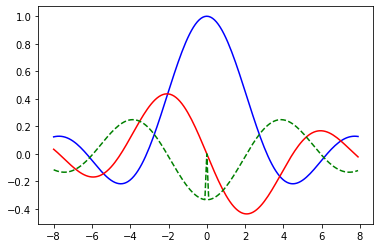

In [6]:
# Let's plot the result
import matplotlib.pyplot as plt
x_range = jnp.arange(-8, 8, .1)
plt.plot(x_range, simple_fun(x_range), 'b')
plt.plot(x_range, [grad_simple_fun(xi) for xi in x_range], 'r')
plt.plot(x_range, [grad_grad_simple_fun(xi) for xi in x_range], '--g')
plt.show()

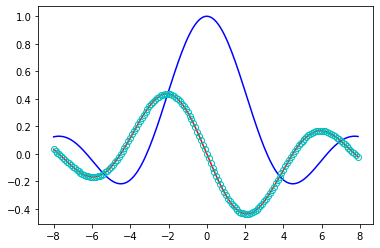

In [7]:
from jax import vmap
# Let's see how vmap can be used to vectorize computations efficiently
# In the example above, we can use vmap instead of loop to compute gradients

grad_vect_simple_fun = vmap(grad_simple_fun)(x_range)

# plot again and check that the gradients are identical 
plt.plot(x_range, simple_fun(x_range), 'b')
plt.plot(x_range, [grad_simple_fun(xi) for xi in x_range], 'r')
plt.plot(x_range, grad_vect_simple_fun, 'oc', mfc='none')
plt.show()


In [ ]:
# Let's time them!

# naive batching
def naively_batched(x):
  return jnp.stack([grad_simple_fun(xi) for xi in x])

# manual batching with jit
@jit
def manual_batched(x):
  return jnp.stack([grad_simple_fun(xi) for xi in x])

# Batching using vmap and jit
@jit
def vmap_batched(x):
  return vmap(grad_simple_fun)(x)

print ('Naively batched')
%timeit naively_batched(x_range).block_until_ready()
print ('jit batched')
%timeit manual_batched(x_range).block_until_ready()
print ('With jit vmap')
%timeit vmap_batched(x_range).block_until_ready()

## Pytrees

The jax ecosystem (including flax and haiku) relies on structured, nested data -- [pytrees](https://jax.readthedocs.io/en/latest/pytrees.html).

*In JAX, a pytree is a container of leaf elements and/or more pytrees. Containers include lists, tuples, and dicts (JAX can be extended to consider other container types as pytrees [...]). A leaf element is anything that’s not a pytree, e.g. an array. In other words, a pytree is just a possibly-nested standard or user-registered Python container. If nested, note that the container types do not need to match. A single “leaf”, i.e. a non-container object, is also considered a pytree.*

Basically a pytree is a generic nested python container, that gives you more control over what structures should act like leaves vs branching containers.

Let's see an example (taken from [this tutorial](https://colab.sandbox.google.com/github/google/jax/blob/master/docs/jax-101/05.1-pytrees.ipynb#scrollTo=9UjxVY9ulSCn)):

In [ ]:
import jax
import jax.numpy as jnp

example_trees = [
    [1, 'a', object()],
    (1, (2, 3), ()),
    [1, {'k1': 2, 'k2': (3, 4)}, 5],
    {'a': 2, 'b': (2, 3)},
    jnp.array([1, 2, 3]),
]

# Let's see how many leaves they have, by using `jax.tree_leaves(pytree)` 
# to access the flattened leaves of the tree
for pytree in example_trees:
  leaves = jax.tree_leaves(pytree)
  print(f"{repr(pytree):<45} has {len(leaves)} leaves: {leaves}")

Places where you commonly find pytrees are:
* Model parameters (e.g. see `get_num_params` function below)
* Dataset entries
* RL agent observations

Check the [tutorial linked above](https://colab.sandbox.google.com/github/google/jax/blob/master/docs/jax-101/05.1-pytrees.ipynb#scrollTo=-h05_PNNhZ-D) for more details and exercises on pytrees.

### For more details on jax, check out this [collection of eight JAX-101 tutorials](https://jax.readthedocs.io/en/latest/jax-101/index.html).

### Also, read the doc for [common gotchas](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html) in JAX!

## Haiku -- object-oriented neural network library on top of JAX

[Haiku](https://github.com/deepmind/dm-haiku) is a simple neural network library for JAX that enables users to use familiar object-oriented programming models while allowing full access to JAX's pure function transformations.

This colab goes through a complete but minimal example training an MLP classifier on MNIST. The [quickstart](https://github.com/deepmind/dm-haiku#quickstart) and [user-manual](https://github.com/deepmind/dm-haiku#user-manual) provide more information.

Notable functions / entities
* `hk.Module` base class: implement your own modules by deriving from it
* `hk.transform`: convert non-pure (objects) functions into pure functions; returns an object with a pair of pure functions `init` and `apply`.
* `hk.next_rng_key()`: returns a unique random key

**Important.**
Do not use jax transforms (grad, jit, etc) with impure functions (e.g. inside Haiku networks). Instead, use them on `hk.transform`ed pure functions, or try the experimental `haiku.grad` and `haiku.jit` etc. 

### Example: Train MLP classifier on MNIST

We also use

* [optax](https://github.com/deepmind/optax) a gradient processing and optimization library.
* tensorflow datasets to load and pre-process data.

In [ ]:
from typing import Any, Mapping, Generator, Tuple 

# we will use haiku on top of jax 
!pip install -q dm-haiku optax
import haiku as hk

import jax
import optax
import jax.numpy as jnp
import numpy as np
import enum

# Dataset library
import tensorflow_datasets as tfds

# Plotting library.
from matplotlib import pyplot as plt
import pylab as pl
from IPython import display

# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
devices = jax.devices()
if not str(devices[0]).startswith('gpu'):
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(devices[0]))

# define some useful types
OptState = Any
Batch = Mapping[str, np.ndarray]

### Define the dataset: MNIST

In [ ]:
# We use TF datasets; JAX does not support data loading or preprocessing.
NUM_CLASSES = 10  # MNIST has 10 classes, corresponding to the different digits.
def load_dataset(
    split: str,
    *,
    is_training: bool,
    batch_size: int,
) -> Generator[Batch, None, None]:
  """Loads the dataset as a generator of batches."""
  ds = tfds.load('mnist:3.*.*', split=split).cache().repeat()
  if is_training:
    ds = ds.shuffle(10 * batch_size, seed=0)
  ds = ds.batch(batch_size)
  return tfds.as_numpy(ds)

In [ ]:
# Function to display images
MAX_IMAGES = 10
def gallery(images, label, title='Input images'):  
  class_dict = [u'zero', u'one', u'two', u'three', u'four', u'five', u'six', u'seven', u'eight', u'nine']
  num_frames, h, w, num_channels = images.shape
  num_frames = min(num_frames, MAX_IMAGES)
  ff, axes = plt.subplots(1, num_frames,
                          figsize=(30, 30),
                          subplot_kw={'xticks': [], 'yticks': []})
  if images.min() < 0:
    images = (images + 1.) / 2.
  for i in range(0, num_frames):
    if num_channels == 3:
      axes[i].imshow(np.squeeze(images[i]))
    else:
      axes[i].imshow(np.squeeze(images[i]), cmap='gray')
    axes[i].set_title(class_dict[label[i]], fontsize=28)
    plt.setp(axes[i].get_xticklabels(), visible=False)
    plt.setp(axes[i].get_yticklabels(), visible=False)
  ff.subplots_adjust(wspace=0.1)
  plt.show()

In [ ]:
# Display some training images with their labels.
# First, create a dataset iterator for fetching batches.
display_dataset_iter = iter(load_dataset('train', is_training=True, batch_size=10))

In [ ]:
# Then get a batch and display it.
display_batch = next(display_dataset_iter)
gallery(display_batch['image'], display_batch['label'])

# To iterate over the dataset, one could also do
# for batch in load_dataset('train', is_training=True, batch_size=10):
#   ..process batch..

In [ ]:
# And check their shapes.
print(display_batch['image'].shape)
print(display_batch['label'].shape)


In [ ]:
#@title Training hyperparams
# There are 60k examples in the training
# data. We consider training batches of 1000 examples.
# We train for 10 epochs with constant learning rate
# of 1e-3.
# We use weight decay (L2 regularization), adding
# the sum of the l2 norms of the weights to the
# loss with a weight of 1e-4.
TRAIN_BATCH_SIZE = 1000  #@param
NUM_EPOCHS = 10  #@param
lr = 1e-3 #@param
WEIGHT_DECAY = 1e-4  #@param

TRAIN_NUM_EXAMPLES = 60000  # Number of training examples in MNIST.


In [ ]:
# Make datasets for train and test
train_dataset = load_dataset('train', is_training=True, batch_size=TRAIN_BATCH_SIZE)
train_eval_dataset = load_dataset('train', is_training=False, batch_size=10000)
test_eval_dataset = load_dataset('test', is_training=False, batch_size=10000)

### Define classifier: a simple MLP

In [ ]:
def net_fn(batch: Batch) -> jnp.ndarray:
  """Standard LeNet-300-100 MLP network."""
  # The images are in [0, 255], uint8; we need to convert to float and normalise 
  x = batch['image'].astype(jnp.float32) / 255.
  # We use hk.Sequential to chain the modules in the network
  mlp = hk.Sequential([
  # The input images are 28x28, so we first flatten them to apply linear (fully-connected) layers                     
      hk.Flatten(),  
      hk.Linear(300), jax.nn.relu,
      hk.Linear(100), jax.nn.relu,
      hk.Linear(NUM_CLASSES),
  ])
  return mlp(x)

### Retrieve pure functions for our model (`init`, `apply`) using `hk.transform`



In [ ]:
# Since we don't store additional state statistics, e.g. needed in batch norm,
# we use `hk.transform`. When we use batch_norm, we will use `hk.transform_with_state`.
# Additionally, since we don't need to inject rng for this simple model, we also 
# apply `hk.without_apply_rng` to remove `rng` from `apply` function.
net = hk.without_apply_rng(hk.transform(net_fn))
# We will use the pure functions as net.init(...) and net.apply(...)

### Define the optimiser

In [ ]:
# We use Adam optimizer here. Others are possible, e.g. sgd with momentum.
opt = optax.adam(lr)

### Define the optimisation objective (loss)

In [ ]:
# Training loss: cross-entropy plus weight decay regularization
def loss(params: hk.Params, batch: Batch) -> jnp.ndarray:
  """Compute the loss of the network, including L2 for regularization."""
  
  # Get network predictions
  logits = net.apply(params, batch)

  # Generate one_hot labels from index classes
  labels = jax.nn.one_hot(batch['label'], NUM_CLASSES)

  # Compute mean softmax cross entropy over the batch
  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
  softmax_xent /= labels.shape[0]

  # Compute the weight decay loss by penalising the norm of parameters
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))
  
  return softmax_xent + WEIGHT_DECAY * l2_loss

### Evaluation metric

In [ ]:
# Classification accuracy
@jax.jit
def accuracy(params: hk.Params, batch: Batch) -> jnp.ndarray:
  # Get network predictions
  predictions = net.apply(params, batch)
  # Return accuracy = how many predictions match the ground truth
  return jnp.mean(jnp.argmax(predictions, axis=-1) == batch['label'])

### Define training step (parameters update)

In [ ]:
@jax.jit
def update(
    params: hk.Params,
    opt_state: OptState,
    batch: Batch,
) -> Tuple[hk.Params, OptState]:
  """Learning rule (stochastic gradient descent)."""
  # Use jax transformation `grad` to compute gradients; 
  # it expects the prameters of the model and the input batch
  grads = jax.grad(loss)(params, batch)

  # Compute parameters updates based on gradients and optimiser state
  updates, opt_state = opt.update(grads, opt_state)

  # Apply updates to parameters
  new_params = optax.apply_updates(params, updates)
  return new_params, opt_state

### Initialise the model, the optimiser and dataset.

In [ ]:
# Initialize the datasets model, optimiser. Note that a sample input is
# needed to compute shapes of parameters.

# Set up dataset iterators.
train_ds_iterator = iter(train_dataset)
train_eval_ds_iterator = iter(train_eval_dataset)
test_eval_ds_iterator = iter(test_eval_dataset)

# Draw a data batch
batch = next(train_ds_iterator)
# Initialize model
params = net.init(jax.random.PRNGKey(42), batch)
#Initialize optimiser
opt_state = opt.init(params)

### Visualise data and parameter shapes

In [ ]:
# Display shapes and images
print(batch['image'].shape)
print(batch['label'].shape)
gallery(batch['image'], batch['label'])

In [ ]:
# Let's see how many parameters in our network and their shapes
def get_num_params(params: hk.Params):
  num_params = 0
  for p in jax.tree_leaves(params): 
    print('param shape:', p.shape)
    num_params = num_params + jnp.prod(jnp.array(p.shape))
  return num_params
print('Total number of parameters %d' % get_num_params(params))

### Accuracy of the untrained model (should be ~10%)

In [ ]:
# Run accuracy on the test dataset
test_accuracy = accuracy(params, next(iter(test_eval_dataset)))
print('Test accuracy %f '% test_accuracy)

In [ ]:
# Let's visualise some network predictions before training; if some are correct,
# they are correct by chance.
predictions = net.apply(params, batch)
pred_labels = jnp.argmax(predictions, axis=-1)
gallery(batch['image'], pred_labels)

### Run one training step

In [ ]:
# First, let's do one step and check if the updates lead to decrease in error
loss_before_train = loss(params, batch) 
print('Loss before train %f' % loss_before_train)
params, opt_state = update(params, opt_state, batch)
new_loss = loss(params, next(train_ds_iterator))
new_loss_same_batch = loss(params, batch)
print('Loss after one step of training, same batch %f, different batch %f' % (new_loss_same_batch, new_loss))

### Run training steps in a loop. We also run evaluation periodically.

In [ ]:
# Train/eval loop.
print("Training..")
for epoch in range(NUM_EPOCHS):
  for step in range(TRAIN_NUM_EXAMPLES // TRAIN_BATCH_SIZE):
    # Evaluate classification accuracy on train & test sets.
    train_accuracy = accuracy(params, next(train_eval_ds_iterator))
    test_accuracy = accuracy(params, next(test_eval_ds_iterator))
    train_accuracy, test_accuracy = jax.device_get(
        (train_accuracy, test_accuracy))

    # Do SGD (Adam) on a batch of training examples.
    params, opt_state = update(params, opt_state, next(train_ds_iterator))
  print('Epoch %d Train / Test accuracy: %f / %f' % (
      epoch+1, train_accuracy, test_accuracy))

### Visualise network predictions after training; most of the predictions should be correct.

In [ ]:
# Get predictions for the same batch
predictions = net.apply(params, batch)
pred_labels = jnp.argmax(predictions, axis=-1)
gallery(batch['image'], pred_labels)

## Flax -- alternative library on top of JAX

[Flax](https://github.com/google/flax) is another neural network library and ecosystem for JAX designed for flexibility.

The link above provides a good quick intro, and the [documentation](https://flax.readthedocs.io/en/latest/index.html) has good examples, including an [annotated MNIST Example](https://colab.sandbox.google.com/github/google/flax/blob/master/docs/notebooks/annotated_mnist.ipynb). We reproduce a version of the MNIST example here, that is analogous to the Haiku section above.

Flax comes with:

* **Neural network API** (`flax.linen`): Dense, Conv, {Batch|Layer|Group} Norm, Attention, Pooling, {LSTM|GRU} Cell, Dropout
* **Optimizers** (`flax.optim`): SGD, Momentum, Adam, LARS, Adagrad, LAMB, RMSprop
* And much more, including utilities, worked examples and tuned, large scale examples.

While flax includes optimizers, we can use `optax` to optimize the parameters in `flax.linen` networks. That is the approach we will take here.


`haiku` and `flax` both provide an OOP interface for neural nets; they both produce `init()` and `apply()` functions for their modules. Some differences you will notice are:

1. Slightly different ways of declaring and working with modules.
2. Different signature for `apply()`.
3. The common `flax` pattern of passing around a full "TrainState", while `haiku` tends to keep `params`, `optimizer_state`, etc separate.

Due to these differences we will rewrite much of the training and evaluation functions from before -- even though the changes are fairly minimal.

To showcase additional features, we will use a simple convnet and SGD with momentum optimizer.

In [ ]:
!pip install -q flax

In [ ]:
from flax import linen as nn           # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

### Define network

Create a convolutional neural network with the Linen API by subclassing
[`Module`](https://flax.readthedocs.io/en/latest/flax.linen.html#core-module-abstraction).
Because the architecture in this example is relatively simple—you're just
stacking layers—you can define the inlined submodules directly within the
`__call__` method and wrap it with the
[`@compact`](https://flax.readthedocs.io/en/latest/flax.linen.html#compact-methods)
decorator.

In [ ]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = x.astype(jnp.float32) / 255
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=NUM_CLASSES)(x)
    return x

We do not need to explicitly retrieve pure functions.

### Create train state (and optimizer)

A common pattern in Flax is to create a single dataclass that represents the
entire training state, including step number, parameters, and optimizer state.

Also adding optimizer & model to this state has the advantage that we only need
to pass around a single argument to functions like `train_step()` (see below).

Because this is such a common pattern, Flax provides the class
[flax.training.train_state.TrainState](https://flax.readthedocs.io/en/latest/flax.training.html#train-state)
that serves most basic use cases. Usually one would subclass it to add more data
to be tracked, but in this example we can use it without any modifications.

In [ ]:
def create_train_state(rng, learning_rate, momentum):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  # In the haiku example, we used Adam. Let's use SGD with momentum here. 
  tx = optax.sgd(learning_rate, momentum)
  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx)

### Define the optimisation objective (loss)

In [ ]:
def flax_loss_fn(params, batch):
  logits = CNN().apply({'params': params}, batch['image'])

  labels = jax.nn.one_hot(batch['label'], NUM_CLASSES)

  # Compute mean softmax cross entropy over the batch
  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(logits))
  softmax_xent /= labels.shape[0]

  # Compute the weight decay loss by penalising the norm of parameters
  l2_loss = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_leaves(params))

  return softmax_xent + WEIGHT_DECAY * l2_loss  

### Evaluation Metric

In [ ]:
# Classification accuracy
@jax.jit
def flax_accuracy(params, batch):
  # Get network predictions
  predictions = CNN().apply({'params': params}, batch['image'])
  # Return accuracy = how many predictions match the ground truth
  return jnp.mean(jnp.argmax(predictions, axis=-1) == batch['label'])

### Define training step (parameters update)

In [ ]:
@jax.jit
def flax_train_step(state, batch):
  """Train for a single step."""
  grads = jax.grad(flax_loss_fn)(state.params, batch)
  state = state.apply_gradients(grads=grads)
  return state

### Initialize the model and the optimiser (train state)

In [ ]:
rng = jax.random.PRNGKey(0)
rng, init_rng = jax.random.split(rng)

In [ ]:
# We define a new (higher) learning rate for SGD and momentum
learning_rate = 0.01
momentum = 0.9

In [ ]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [ ]:
# Compare the number of params in this CNN to the haiku MLP 
print('Total number of parameters %d' % get_num_params(state.params))

### Accuracy of the untrained model

In [ ]:
# Run accuracy on the test dataset
test_accuracy = flax_accuracy(state.params, next(iter(test_eval_dataset)))
print('Test accuracy %f '% test_accuracy)

### Run training steps in a loop. We also run evaluation periodically.

In [ ]:
# Train/eval loop.
print("Getting data iterators..")
train_ds_iterator = iter(train_dataset)
train_eval_ds_iterator = iter(train_eval_dataset)
test_eval_ds_iterator = iter(test_eval_dataset)

print("Training..")
for epoch in range(NUM_EPOCHS):
  for step in range(TRAIN_NUM_EXAMPLES // TRAIN_BATCH_SIZE):
    # Do SGD on a batch of training examples.
    state = flax_train_step(state, next(train_ds_iterator))
  # Periodically evaluate classification accuracy on train & test sets.
  train_accuracy = flax_accuracy(state.params, next(train_eval_ds_iterator))
  test_accuracy = flax_accuracy(state.params, next(test_eval_ds_iterator))
  train_accuracy, test_accuracy = jax.device_get(
      (train_accuracy, test_accuracy))
  print('epoch %d Train / Test accuracy: %f / %f' % (epoch+1, train_accuracy, test_accuracy))
